!["search-engine"](./images/search-engine.jpg)

In [47]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from annoy import AnnoyIndex

from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from keras import optimizers
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras.losses import cosine_proximity
from keras.models import Model
from keras.applications.vgg16 import VGG16

import os
import random
import logging
import time

%matplotlib inline

In [36]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [37]:
DATA_PATH = "./data/"
GLOVE_PATH = "./glove/"
# If running this notebook for the first time,set below value to TRUE
FIRST_TIME = True

In [123]:
def load_glove_vectors(glove_dir, glove_name='glove.6B.300d.txt'):
    """
    Mostly from keras docs here https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
    :param glove_name: name of pre-trained file
    :param glove_dir: directory in witch the glove file is located
    :return:
    """
    f = open(os.path.join(glove_dir, glove_name), encoding='utf8')
    embeddings_index = {}
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [124]:
word_vectors = load_glove_vectors(GLOVE_PATH)

Found 400000 word vectors.


In [40]:
def load_paired_img_wrd(folder, word_vectors, use_word_vectors=True):
    class_names = [fold for fold in os.listdir(folder) if ".DS" not in fold]
    image_list = []
    labels_list = []
    paths_list = []
    for cl in class_names:
        splits = cl.split("_")
        if use_word_vectors:
            vectors = np.array([word_vectors[split] if split in word_vectors else np.zeros(shape=300) for split in splits])
            class_vector = np.mean(vectors, axis=0)
        subfiles = [f for f in os.listdir(folder + "/" + cl) if ".DS" not in f]

        for subf in subfiles:
            full_path = os.path.join(folder, cl, subf)
            img = image.load_img(full_path, target_size=(224, 224))
            x_raw = image.img_to_array(img)
            x_expand = np.expand_dims(x_raw, axis=0)
            x = preprocess_input(x_expand)
            image_list.append(x)
            if use_word_vectors:
                labels_list.append(class_vector)
            paths_list.append(full_path)
    img_data = np.array(image_list)
    img_data = np.rollaxis(img_data, 1, 0)
    img_data = img_data[0]
    logger.info("Images preprocessed")

    return img_data, np.array(labels_list), paths_list

In [41]:
images, vectors, image_paths = load_paired_img_wrd(DATA_PATH, word_vectors)

# Visualizing the data

In [64]:
def show_images(images, labels):
    # Create a figure with sub-plots
    fig, axes = plt.subplots(3, 3, figsize = (8,8))
    hspace = 0.5
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Plot the image
            ax.imshow(images[i], interpolation='spline16')
            xlabel = labels[i]
            ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [43]:
class_names = [fold for fold in os.listdir(DATA_PATH) if ".DS" not in fold]
temp_images = []
for cl in class_names:
    r_index = random.randint(0, 75)
    subfiles = os.listdir(DATA_PATH + "/" + cl)
    subf = subfiles[r_index]
    full_path = os.path.join(DATA_PATH, cl, subf)
    temp_images.append(image.load_img(full_path, target_size=(224, 224)))

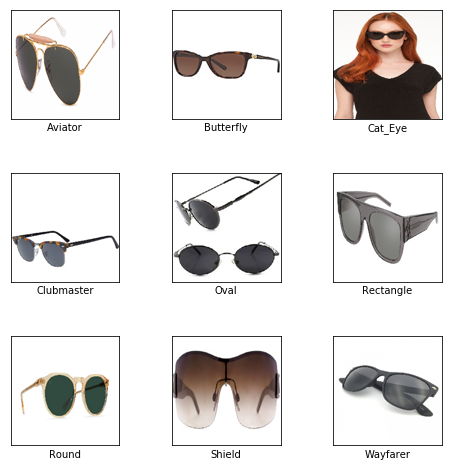

In [116]:
# plot_images(temp_images, class_names, class_names, labels_pred=None)
show_images(temp_images, class_names)

# Load Pretrained VGG16 model

Here I am generating the image features for all the input images and then **storing them to the disk**. This way you can re-use the image features without making a forward pass of the network.

In [33]:
pretrained_vgg16 = VGG16(weights='imagenet', include_top=True)
model = Model(inputs=pretrained_vgg16.input,
                  outputs=pretrained_vgg16.get_layer('fc2').output)

553467904/553467096 [==============================] - 40s 0us/step


In [48]:
start = time.time()
if FIRST_TIME:
    images_features = model.predict(images)
    file_mapping = {i: f for i, f in enumerate(image_paths)}
    np.save('%s.npy' % "trained_features", images_features)
# else:
#     images_features, file_index = vector_search.load_features(features_path, file_mapping_path)

# Using Annoy to build a fast-index

Annoy(Approximate Nearest Neighbors Oh Yeah) is a C++ library with Python bindings to search for points in space that are close to a given query point. It also creates large read-only file-based data structures that are mmapped into memory so that many processes may share the same data.

#### Spotify uses Annoy for music recommendations. After running a matrix factorization algorithm, every user/item is represented as a vector in n-dimensional space.

You can learn more about it [here](https://github.com/spotify/annoy)

In [50]:
feature_index = AnnoyIndex(4096, metric='angular')
for i, row in enumerate(images_features):
    feature_index.add_item(i, row)
feature_index.build(1000)

True

In [161]:
file_mapping[100]

'./data/Butterfly\\32. new-fashion-oversized-butterfly-sunglasses-women-polarized-uv400-brand-designer-2017-high-quality-sun-glasses-for.jpg'

## Searching an Image

To search a particular image, we simply get its embeddings and look into the fast index we created above to find similar embeddings i.e. similar images.

In [96]:
def search_images_by_index(index, feature_index, file_mapping, top_n=10):
    distances = feature_index.get_nns_by_item(index, top_n, include_distances=True)
    return [[a, file_mapping[a], distances[1][i]] for i, a in enumerate(distances[0])]

([], <a list of 0 Text yticklabel objects>)

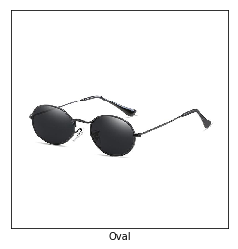

In [113]:
search_ind = 345
input_image = image.load_img(file_mapping[search_ind], target_size=(224, 224))
input_label = file_mapping[search_ind].split('/')[2].split('\\')[0]
plt.imshow(input_image)
plt.xlabel(input_label)
plt.xticks([])
plt.yticks([])

# Results

Most-similar images to the above image.



In [114]:
results = search_images_by_index(search_ind, feature_index, file_mapping)

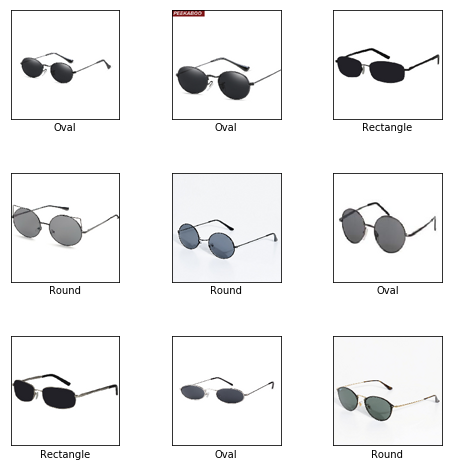

In [115]:
result_images = [image.load_img(row[1], target_size=(224, 224)) for index, row in enumerate(results)]
result_labels = [row[1].split('/')[2].split('\\')[0] for index, row in enumerate(results)]
show_images(result_images, result_labels)

In [102]:
# result_images = [image.load_img(row[1], target_size=(224, 224)) for index, row in enumerate(results)]
# result_labels = [row[2] for index, row in enumerate(results)]
# show_images(result_images, result_labels)

# Image based Dog-search

The below code section uses a different dataset; subset of dog-breed-identification challenge on Kaggle. I have followed the same steps as above to build image representations (embeddings) and do a similarity search.

In [135]:
DOG_DATA_PATH = "./dog_data/"

In [136]:
dog_images, dog_vectors, dog_image_paths = load_paired_img_wrd(DOG_DATA_PATH, word_vectors)

In [137]:
dog_class_names = [fold for fold in os.listdir(DOG_DATA_PATH) if ".DS" not in fold]
temp_dog_images = []
for cl in dog_class_names:
    r_index = random.randint(0, 50)
    subfiles = os.listdir(DOG_DATA_PATH + "/" + cl)
    subf = subfiles[r_index]
    full_path = os.path.join(DOG_DATA_PATH, cl, subf)
    temp_dog_images.append(image.load_img(full_path, target_size=(224, 224)))

### Visualizing the dataset

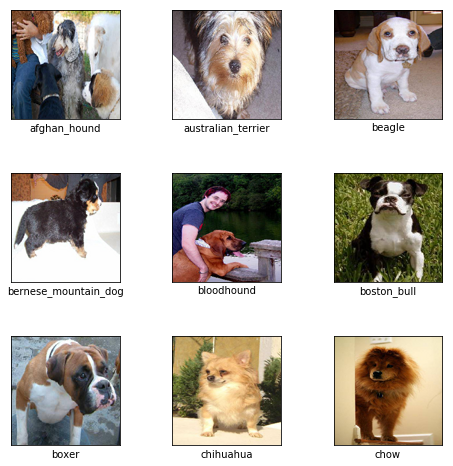

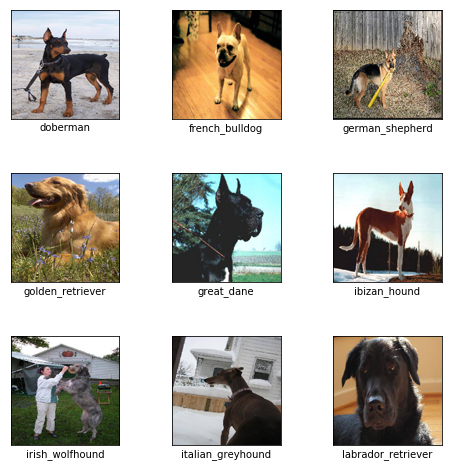

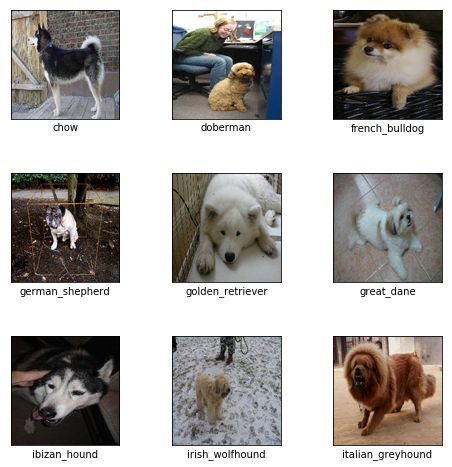

In [140]:
show_images(temp_dog_images[0:9], dog_class_names[0:9])
show_images(temp_dog_images[9:18], dog_class_names[9:18])
show_images(temp_dog_images[18:27], dog_class_names[8:27])

### Generating image features

In [141]:
start = time.time()
if FIRST_TIME:
    dog_images_features = model.predict(dog_images)
    dog_file_mapping = {i: f for i, f in enumerate(dog_image_paths)}
    np.save('%s.npy' % "dog_trained_features", dog_images_features)
# else:
#     images_features, file_index = vector_search.load_features(features_path, file_mapping_path)
print("Took: ", time.time() - start, " seconds!")

Took:  1360.8946731090546  seconds!


In [142]:
dog_feature_index = AnnoyIndex(4096, metric='angular')
for i, row in enumerate(dog_images_features):
    dog_feature_index.add_item(i, row)
dog_feature_index.build(1000)

True

### Input Image (Image to search)

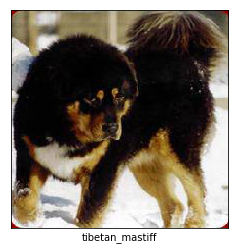

In [154]:
search_ind = 1750
input_image = image.load_img(dog_file_mapping[search_ind], target_size=(224, 224))
input_label = dog_file_mapping[search_ind].split('/')[2].split('\\')[0]
plt.xticks([])
plt.yticks([])
plt.xlabel(input_label)
plt.imshow(input_image)

### Results

In [155]:
dog_results = search_images_by_index(search_ind, dog_feature_index, dog_file_mapping)

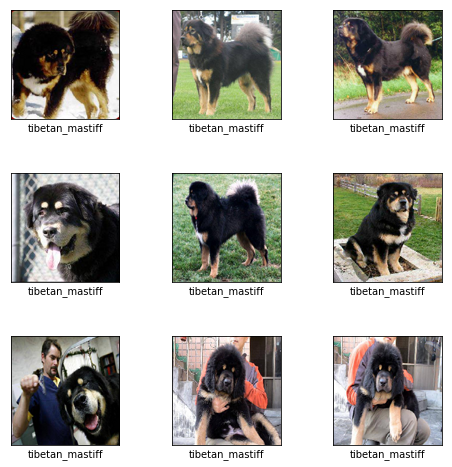

In [156]:
dog_result_images = [image.load_img(row[1], target_size=(224, 224)) for index, row in enumerate(dog_results)]
dog_result_labels = [row[1].split('/')[2].split('\\')[0] for index, row in enumerate(dog_results)]
show_images(dog_result_images, dog_result_labels)